In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stereo-raft-depth/images/gt_disp/491.png
/kaggle/input/stereo-raft-depth/images/gt_disp/480.png
/kaggle/input/stereo-raft-depth/images/gt_disp/513.png
/kaggle/input/stereo-raft-depth/images/gt_disp/511.png
/kaggle/input/stereo-raft-depth/images/gt_disp/506.png
/kaggle/input/stereo-raft-depth/images/gt_disp/505.png
/kaggle/input/stereo-raft-depth/images/gt_disp/493.png
/kaggle/input/stereo-raft-depth/images/gt_disp/500.png
/kaggle/input/stereo-raft-depth/images/gt_disp/492.png
/kaggle/input/stereo-raft-depth/images/gt_disp/468.png
/kaggle/input/stereo-raft-depth/images/gt_disp/466.png
/kaggle/input/stereo-raft-depth/images/gt_disp/515.png
/kaggle/input/stereo-raft-depth/images/gt_disp/488.png
/kaggle/input/stereo-raft-depth/images/gt_disp/501.png
/kaggle/input/stereo-raft-depth/images/gt_disp/484.png
/kaggle/input/stereo-raft-depth/images/gt_disp/471.png
/kaggle/input/stereo-raft-depth/images/gt_disp/467.png
/kaggle/input/stereo-raft-depth/images/gt_disp/473.png
/kaggle/in

In [2]:
import os
import sys
import numpy as np
import cv2
import pandas as pd
import torch
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import glob
from PIL import Image
from types import SimpleNamespace

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
!git clone https://github.com/princeton-vl/RAFT.git

#Download pretrained models
%cd RAFT
!./download_models.sh
%cd ..

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 147 (delta 0), reused 0 (delta 0), pack-reused 146 (from 2)
Receiving objects: 100% (147/147), 10.01 MiB | 46.61 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/kaggle/working/RAFT
--2025-08-16 15:43:20--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  1.49MB/s    in 59s     

2025-08-16 15:44:20 (1.33 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating:

In [4]:
import sys
sys.path.append('/kaggle/working/RAFT')  # Main RAFT directory
sys.path.append('/kaggle/working/RAFT/core')  # Core directory if needed

In [5]:
# Import RAFT components
from raft import RAFT
from utils.utils import InputPadder

In [6]:
ls -lh /kaggle/working/RAFT/models/raft-stereo.pth

ls: cannot access '/kaggle/working/RAFT/models/raft-stereo.pth': No such file or directory


In [7]:
import numpy as np
import torch
import torch.nn as nn
import cv2
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from raft import RAFT
from utils.utils import InputPadder  # from RAFT repo
from argparse import Namespace
from torch.cuda.amp import autocast

# =============== CONFIGURATION ===============
left_dir = '/kaggle/input/stereo-raft-depth/images/left'
right_dir = '/kaggle/input/stereo-raft-depth/images/right'
gt_disp_dir = '/kaggle/input/stereo-raft-depth/images/gt_disp'
gt_depth_dir = '/kaggle/input/stereo-raft-depth/images/gt_depth'
results_dir = '/kaggle/working/results' 
num_pairs_to_process = 3

# Camera intrinsics
BASELINE = 0.4  # meters
FOCAL_LENGTH = 658.5570007600752  # pixels (K[0][0])

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# =============== MODEL SETUP ===============
def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device(device))
    model = nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to(device)
    model.eval()
    return model

# =============== DATA LOADING ===============
def load_image(imfile):
    img = np.array(Image.open(imfile))
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    img = img[:3]  # drop alpha if present
    img = (img - 127.5) / 127.5  # normalize [-1,1]
    return img[None].to(device)

def load_gt_disp(disp_path):
    disp = np.array(Image.open(disp_path)).astype(np.float32)
    disp[disp <= 0] = 0  # keep invalid as 0
    return torch.from_numpy(disp).unsqueeze(0).to(device)

def load_gt_depth(depth_path):
    depth = np.array(Image.open(depth_path)).astype(np.float32)
    depth[depth <= 0] = 0
    return torch.from_numpy(depth).unsqueeze(0).to(device)

def disparity_to_depth(disp):
    depth = torch.zeros_like(disp)
    valid_mask = disp > 0
    depth[valid_mask] = (BASELINE * FOCAL_LENGTH) / (disp[valid_mask])
    return depth

# =============== METRICS & VISUALIZATION ===============
def compute_metrics(pred_disp, gt_disp, pred_depth, gt_depth):
    # ================= VALIDITY MASKS =================
    disp_mask = (gt_disp > 5) & (gt_disp < 100) & torch.isfinite(gt_disp) & (gt_disp != 0)
    depth_mask = (gt_depth > 1) & (gt_depth < 100) & torch.isfinite(gt_depth) & (gt_depth != 0)

    # Count validity
    total_disp_count = gt_disp.numel()
    total_depth_count = gt_depth.numel()
    valid_disp_count = disp_mask.sum().item()
    valid_depth_count = depth_mask.sum().item()
    valid_disp_pct = 100.0 * valid_disp_count / total_disp_count if total_disp_count > 0 else 0.0
    valid_depth_pct = 100.0 * valid_depth_count / total_depth_count if total_depth_count > 0 else 0.0

    print(f"[VALIDITY] Disparity: {valid_disp_count}/{total_disp_count} ({valid_disp_pct:.2f}%)")
    print(f"[VALIDITY] Depth:     {valid_depth_count}/{total_depth_count} ({valid_depth_pct:.2f}%)")

    # ================= FILTER VALID PIXELS =================
    pred_disp_valid = pred_disp[disp_mask]
    gt_disp_valid   = gt_disp[disp_mask]
    pred_depth_valid = pred_depth[depth_mask]
    gt_depth_valid   = gt_depth[depth_mask]

    # ================= ERRORS =================
    disp_abs_diff = (pred_disp_valid - gt_disp_valid).abs()
    disp_rel_diff = disp_abs_diff / (gt_disp_valid + 1e-6)

    depth_abs_diff = (pred_depth_valid - gt_depth_valid).abs()
    depth_rel_diff = depth_abs_diff / (gt_depth_valid + 1e-6)

    # Near/far split
    near_mask = depth_mask & (gt_depth < 20)
    far_mask  = depth_mask & (gt_depth >= 20)

    def safe_mean(t): 
        return t.mean().item() if t.numel() > 0 else 0.0
    
    def safe_fraction(t, thr): 
        return (t < thr).float().mean().item() if t.numel() > 0 else 0.0

    # ================= RETURN METRICS =================
    return {
        'disp_avg_err': safe_mean(disp_abs_diff),
        'disp_rel_err': safe_mean(disp_rel_diff),
        'disp_delta1': safe_fraction(disp_rel_diff, 0.05),

        'depth_avg_err': safe_mean(depth_abs_diff),
        'depth_rel_err': safe_mean(depth_rel_diff),
        'depth_delta1': safe_fraction(depth_rel_diff, 0.05),

        'invalid_pct': 1.0 - (valid_disp_count / total_disp_count if total_disp_count > 0 else 0.0),

        'depth_err_near': safe_mean((pred_depth[near_mask] - gt_depth[near_mask]).abs()),
        'depth_err_far': safe_mean((pred_depth[far_mask] - gt_depth[far_mask]).abs())
    }


# def visualize_results(pred_disp, gt_disp, pred_depth, gt_depth, base_name):
#     fig, axes = plt.subplots(2, 3, figsize=(18, 12))

#     axes[0,0].imshow(pred_disp.squeeze().cpu().numpy(), cmap='jet', vmin=0, vmax=100)
#     axes[0,0].set_title('Predicted Disparity (px)')

#     axes[0,1].imshow(gt_disp.squeeze().cpu().numpy(), cmap='jet', vmin=0, vmax=100)
#     axes[0,1].set_title('GT Disparity (px)')

#     axes[0,2].imshow((pred_disp-gt_disp).abs().squeeze().cpu().numpy(),
#                      cmap='hot', vmin=0, vmax=20)
#     axes[0,2].set_title('Disparity Error (px)')

#     axes[1,0].imshow(pred_depth.squeeze().cpu().numpy(), cmap='magma', vmin=0, vmax=50)
#     axes[1,0].set_title('Predicted Depth (m)')

#     axes[1,1].imshow(gt_depth.squeeze().cpu().numpy(), cmap='magma', vmin=0, vmax=50)
#     axes[1,1].set_title('GT Depth (m)')

#     axes[1,2].imshow((pred_depth-gt_depth).abs().squeeze().cpu().numpy(),
#                      cmap='hot', vmin=0, vmax=5)
#     axes[1,2].set_title('Depth Error (m)')

#     plt.tight_layout()
#     plt.savefig(os.path.join(results_dir, f"{base_name}_comparison.png"))
#     plt.close()

# =============== MAIN PROCESSING ===============
def process_pairs(left_paths, right_paths, disp_paths, depth_paths, model, num_pairs=3):
    os.makedirs(results_dir, exist_ok=True)
    metrics = []

    for i in range(min(num_pairs, len(left_paths))):
        base_name = os.path.splitext(os.path.basename(left_paths[i]))[0]
        print(f"\nProcessing pair {i+1}: {base_name}")

        image1 = load_image(left_paths[i])
        image2 = load_image(right_paths[i])
        gt_disp = load_gt_disp(disp_paths[i])
        gt_depth = load_gt_depth(depth_paths[i])

        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        with torch.no_grad():
            with autocast(enabled=True):
                _, flow_up = model(image1, image2, iters=32, test_mode=True)

        print("flow_up shape:", flow_up.shape)
        print("Horizontal flow min/max:", flow_up[0, 0].min().item(), flow_up[0, 0].max().item())
        print("Vertical flow min/max:", flow_up[0, 1].min().item(), flow_up[0, 1].max().item())

        if flow_up[0,1].abs().mean().item() > 2:
            print("[WARN] Large vertical flow detected — check rectification!")

        pred_disp = -flow_up[0, 0:1]
        pred_disp[pred_disp <= 0] = 0
        pred_depth = disparity_to_depth(pred_disp)

        np.save(os.path.join(results_dir, f"{base_name}_disp.npy"), pred_disp.squeeze().cpu().numpy())
        np.save(os.path.join(results_dir, f"{base_name}_depth.npy"), pred_depth.squeeze().cpu().numpy())

        current_metrics = compute_metrics(pred_disp, gt_disp, pred_depth, gt_depth)
        metrics.append(current_metrics)

        #visualize_results(pred_disp, gt_disp, pred_depth, gt_depth, base_name)
        print("Metrics:", {k: round(v, 4) for k, v in current_metrics.items()})

    if metrics:
        avg_metrics = {k: np.mean([m[k] for m in metrics]) for k in metrics[0].keys()}
        print("\nAverage Metrics:")
        for k, v in avg_metrics.items():
            print(f"{k:>15}: {v:.4f}")

# =============== MAIN EXECUTION ===============
if __name__ == '__main__':
    required_dirs = [left_dir, right_dir, gt_disp_dir, gt_depth_dir]
    if not all(os.path.exists(d) for d in required_dirs):
        raise FileNotFoundError("Missing input directories")

    left_paths = sorted(glob.glob(os.path.join(left_dir, '*.png')))
    right_paths = sorted(glob.glob(os.path.join(right_dir, '*.png')))
    disp_paths = sorted(glob.glob(os.path.join(gt_disp_dir, '*.png')))
    depth_paths = sorted(glob.glob(os.path.join(gt_depth_dir, '*.png')))

    if not len(left_paths) == len(right_paths) == len(disp_paths) == len(depth_paths):
        raise ValueError("Mismatched number of files across directories")

    print(f"Found {len(left_paths)} complete stereo pairs")

    args = Namespace(
        model='raft-things',
        path='RAFT/models',
        small=False,
        mixed_precision=True,
        alternate_corr=False,
        dropout=0.0,
        corr_levels=4,
        corr_radius=4
    )

    model = load_model(os.path.join(args.path, f"{args.model}.pth"), args)
    process_pairs(left_paths, right_paths, disp_paths, depth_paths, model, num_pairs_to_process)


Using device: cuda
Found 50 complete stereo pairs

Processing pair 1: 466


/tmp/ipykernel_19/4041789559.py:166: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/kaggle/working/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/kaggle/working/RAFT/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/kaggle/working/RAFT/core/raft.py:127: FutureWarning: `torch.cud

flow_up shape: torch.Size([1, 2, 1200, 1920])
Horizontal flow min/max: -129.32760620117188 1.6507701873779297
Vertical flow min/max: -23.817110061645508 11.513998031616211
[VALIDITY] Disparity: 1599241/2304000 (69.41%)
[VALIDITY] Depth:     2054817/2304000 (89.18%)
Metrics: {'disp_avg_err': 1.9815, 'disp_rel_err': 0.1554, 'disp_delta1': 0.7414, 'depth_avg_err': 5.1274, 'depth_rel_err': 0.2837, 'depth_delta1': 0.4823, 'invalid_pct': 0.3059, 'depth_err_near': 3.1067, 'depth_err_far': 8.0754}

Processing pair 2: 467
flow_up shape: torch.Size([1, 2, 1200, 1920])
Horizontal flow min/max: -128.96835327148438 0.3304443955421448
Vertical flow min/max: -22.511943817138672 6.419342517852783
[VALIDITY] Disparity: 1601921/2304000 (69.53%)
[VALIDITY] Depth:     2054430/2304000 (89.17%)
Metrics: {'disp_avg_err': 2.2759, 'disp_rel_err': 0.212, 'disp_delta1': 0.7583, 'depth_avg_err': 3.9635, 'depth_rel_err': 0.1607, 'depth_delta1': 0.5173, 'invalid_pct': 0.3047, 'depth_err_near': 0.6534, 'depth_err_fa

Using device: cuda
Found 50 complete stereo pairs

Processing pair 1: 466


/tmp/ipykernel_19/3136626539.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


flow_up shape: torch.Size([1, 2, 1200, 1920])
Horizontal flow min/max: -129.32760620117188 1.6507701873779297
Vertical flow min/max: -23.817110061645508 11.513998031616211
[VALIDITY] Disparity: 1984439/2304000 (86.13%)
[VALIDITY] Depth:     2021454/2304000 (87.74%)


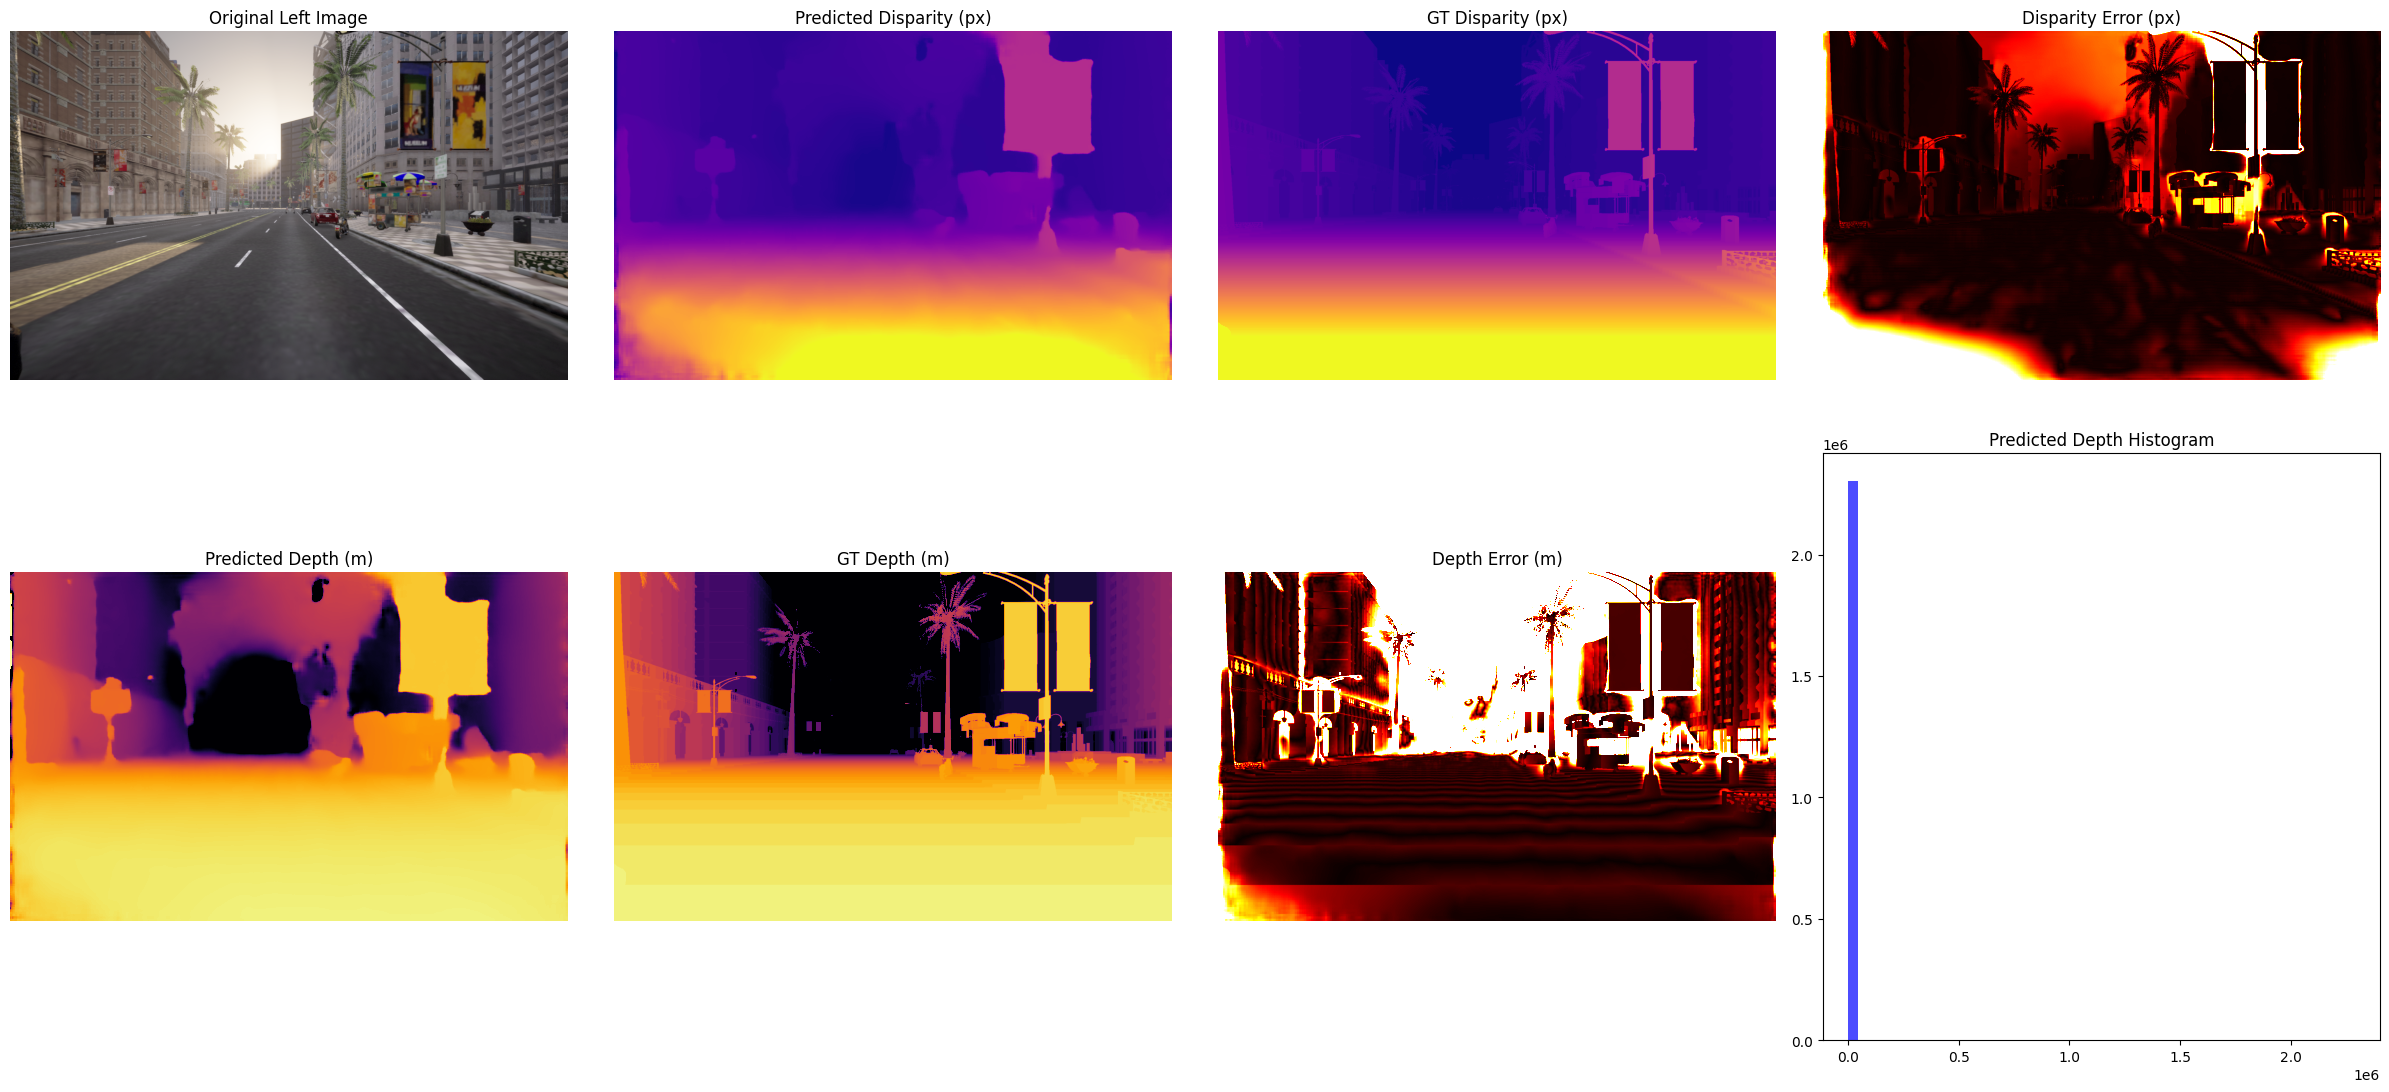

Metrics: {'disp_avg_err': 4.8408, 'disp_rel_err': 0.2181, 'disp_delta1': 0.6699, 'depth_avg_err': 4.3911, 'depth_rel_err': 0.2794, 'depth_delta1': 0.4899, 'invalid_pct': 0.1387, 'depth_err_near': 3.1067, 'depth_err_far': 6.3427}

Processing pair 2: 467
flow_up shape: torch.Size([1, 2, 1200, 1920])
Horizontal flow min/max: -128.96835327148438 0.3304443955421448
Vertical flow min/max: -22.511943817138672 6.419342517852783
[VALIDITY] Disparity: 1983821/2304000 (86.10%)
[VALIDITY] Depth:     2019756/2304000 (87.66%)


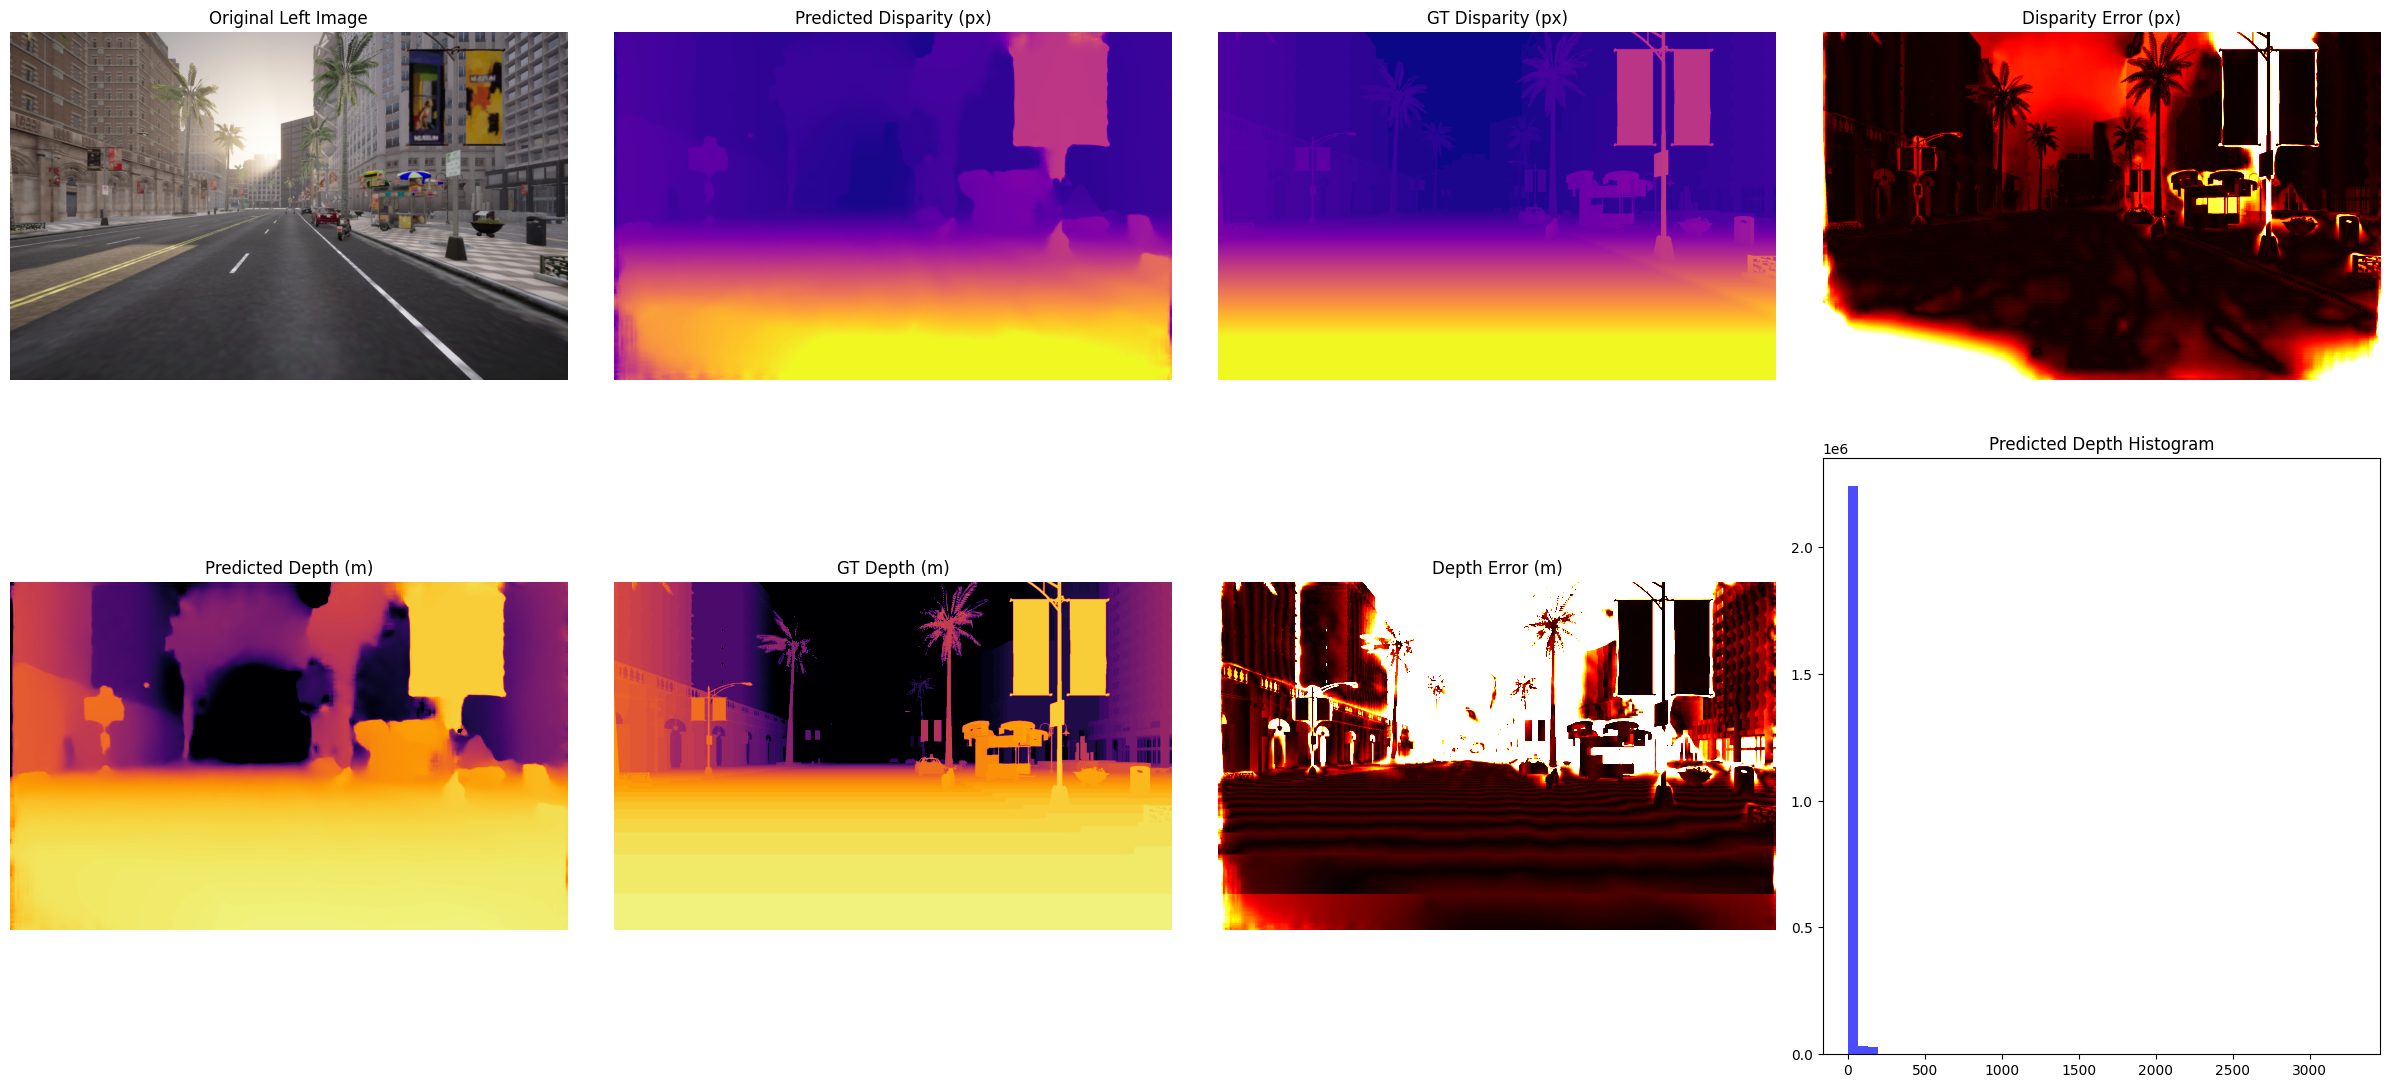

Metrics: {'disp_avg_err': 4.5021, 'disp_rel_err': 0.2394, 'disp_delta1': 0.6855, 'depth_avg_err': 3.1513, 'depth_rel_err': 0.1538, 'depth_delta1': 0.526, 'invalid_pct': 0.139, 'depth_err_near': 0.6534, 'depth_err_far': 7.0495}

Processing pair 3: 468
flow_up shape: torch.Size([1, 2, 1200, 1920])
Horizontal flow min/max: -128.57472229003906 -0.49014049768447876
Vertical flow min/max: -25.219844818115234 4.632653713226318
[VALIDITY] Disparity: 1983816/2304000 (86.10%)
[VALIDITY] Depth:     2018215/2304000 (87.60%)


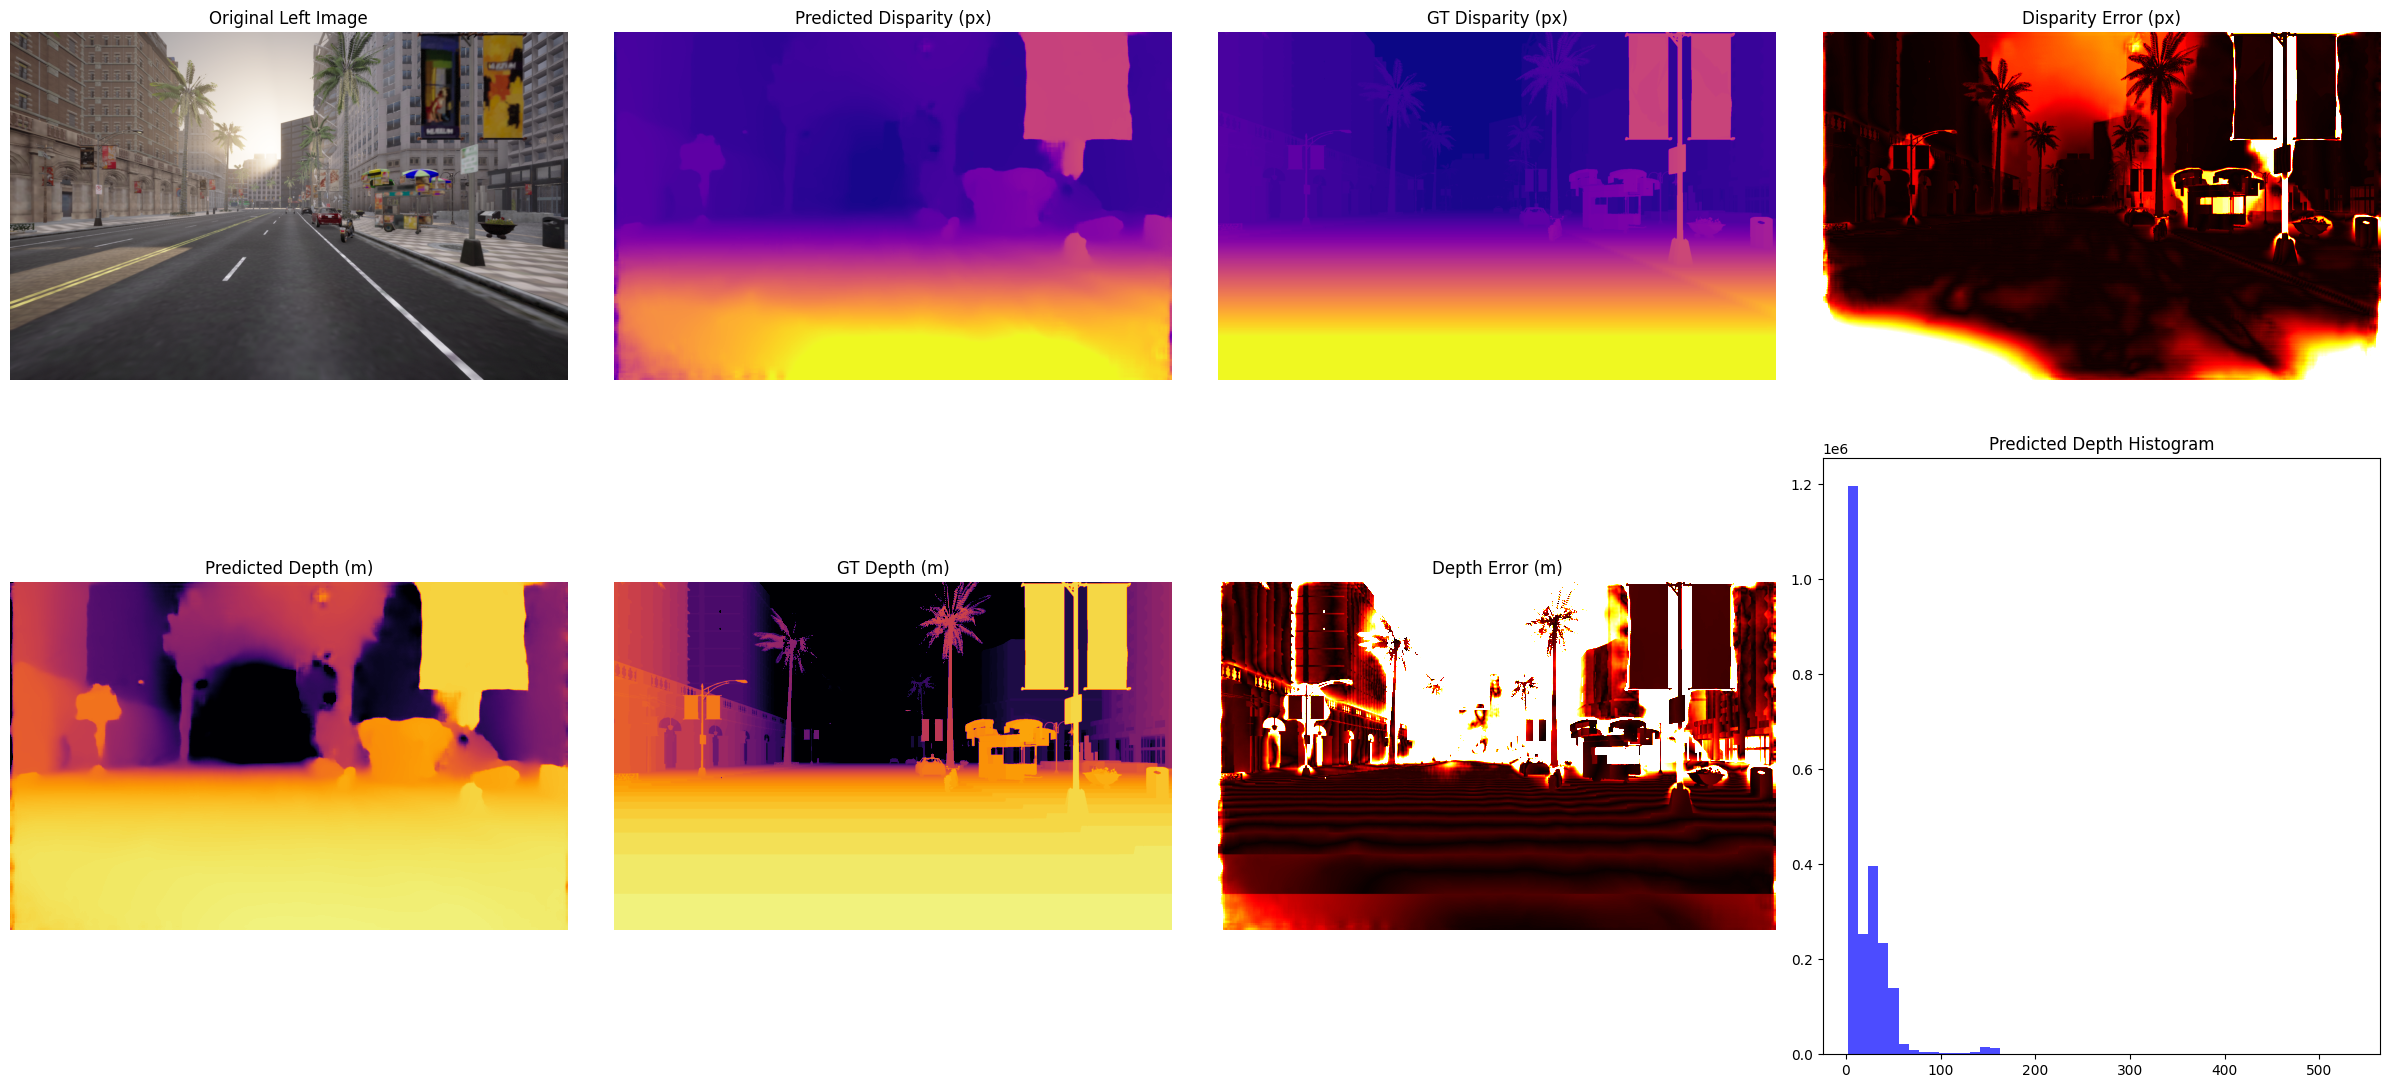

Metrics: {'disp_avg_err': 4.8289, 'disp_rel_err': 0.2181, 'disp_delta1': 0.6654, 'depth_avg_err': 2.8719, 'depth_rel_err': 0.1544, 'depth_delta1': 0.4642, 'invalid_pct': 0.139, 'depth_err_near': 0.6629, 'depth_err_far': 6.5221}

Average Metrics:
   disp_avg_err: 4.7239
   disp_rel_err: 0.2252
    disp_delta1: 0.6736
  depth_avg_err: 3.4714
  depth_rel_err: 0.1959
   depth_delta1: 0.4934
    invalid_pct: 0.1389
 depth_err_near: 1.4743
  depth_err_far: 6.6381


In [8]:
import numpy as np
import torch
import torch.nn as nn
import cv2
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from raft import RAFT
from utils.utils import InputPadder  # from RAFT repo
from argparse import Namespace
from torch.cuda.amp import autocast

# =============== CONFIGURATION ===============
left_dir = '/kaggle/input/stereo-raft-depth/images/left'
right_dir = '/kaggle/input/stereo-raft-depth/images/right'
gt_disp_dir = '/kaggle/input/stereo-raft-depth/images/gt_disp'
gt_depth_dir = '/kaggle/input/stereo-raft-depth/images/gt_depth'
results_dir = '/kaggle/working/results' 
num_pairs_to_process = 3

# Camera intrinsics
BASELINE = 0.4  # meters
FOCAL_LENGTH = 658.5570007600752  # pixels (K[0][0])

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# =============== MODEL SETUP ===============
def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device(device))
    model = nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to(device)
    model.eval()
    return model

# =============== DATA LOADING ===============
def load_image(imfile):
    img = np.array(Image.open(imfile))
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    img = img[:3]  # drop alpha if present
    img = (img - 127.5) / 127.5  # normalize [-1,1]
    return img[None].to(device)

def load_gt_disp(disp_path):
    disp = np.array(Image.open(disp_path)).astype(np.float32)
    disp[disp <= 0] = 0  # keep invalid as 0
    return torch.from_numpy(disp).unsqueeze(0).to(device)

def load_gt_depth(depth_path):
    depth = np.array(Image.open(depth_path)).astype(np.float32)
    depth[depth <= 0] = 0
    return torch.from_numpy(depth).unsqueeze(0).to(device)

def disparity_to_depth(disp):
    depth = torch.zeros_like(disp)
    valid_mask = disp > 0
    depth[valid_mask] = (BASELINE * FOCAL_LENGTH) / (disp[valid_mask])
    return depth

# =============== METRICS & VISUALIZATION ===============
def compute_metrics(pred_disp, gt_disp, pred_depth, gt_depth):
    # ================= VALIDITY MASKS =================
    
    disp_mask  = (gt_disp > 4) & (gt_disp < 263) & torch.isfinite(gt_disp) & (gt_disp != 0)
    depth_mask = (gt_depth > 1) & (gt_depth < 80) & torch.isfinite(gt_depth) & (gt_depth != 0)

    # disp_mask = (gt_disp > 5) & (gt_disp < 100) & torch.isfinite(gt_disp) & (gt_disp != 0)
    # depth_mask = (gt_depth > 1) & (gt_depth < 100) & torch.isfinite(gt_depth) & (gt_depth != 0)
    
    # disp_mask = (gt_disp > 0) & (gt_disp < 300) & torch.isfinite(gt_disp) & (gt_disp != 0)   # instead of 5–100
    # depth_mask = (gt_depth > 0.1) & (gt_depth < 200)& torch.isfinite(gt_depth) & (gt_depth != 0)  # instead of 1–100


    # Count validity
    total_disp_count = gt_disp.numel()
    total_depth_count = gt_depth.numel()
    valid_disp_count = disp_mask.sum().item()
    valid_depth_count = depth_mask.sum().item()
    valid_disp_pct = 100.0 * valid_disp_count / total_disp_count if total_disp_count > 0 else 0.0
    valid_depth_pct = 100.0 * valid_depth_count / total_depth_count if total_depth_count > 0 else 0.0

    print(f"[VALIDITY] Disparity: {valid_disp_count}/{total_disp_count} ({valid_disp_pct:.2f}%)")
    print(f"[VALIDITY] Depth:     {valid_depth_count}/{total_depth_count} ({valid_depth_pct:.2f}%)")

    # ================= FILTER VALID PIXELS =================
    pred_disp_valid = pred_disp[disp_mask]
    gt_disp_valid   = gt_disp[disp_mask]
    pred_depth_valid = pred_depth[depth_mask]
    gt_depth_valid   = gt_depth[depth_mask]

    # ================= ERRORS =================
    disp_abs_diff = (pred_disp_valid - gt_disp_valid).abs()
    disp_rel_diff = disp_abs_diff / (gt_disp_valid + 1e-6)

    depth_abs_diff = (pred_depth_valid - gt_depth_valid).abs()
    depth_rel_diff = depth_abs_diff / (gt_depth_valid + 1e-6)

    # Near/far split
    near_mask = depth_mask & (gt_depth < 20)
    far_mask  = depth_mask & (gt_depth >= 20)

    def safe_mean(t): 
        return t.mean().item() if t.numel() > 0 else 0.0
    
    def safe_fraction(t, thr): 
        return (t < thr).float().mean().item() if t.numel() > 0 else 0.0

    # ================= RETURN METRICS =================
    return {
        'disp_avg_err': safe_mean(disp_abs_diff),
        'disp_rel_err': safe_mean(disp_rel_diff),
        'disp_delta1': safe_fraction(disp_rel_diff, 0.05),

        'depth_avg_err': safe_mean(depth_abs_diff),
        'depth_rel_err': safe_mean(depth_rel_diff),
        'depth_delta1': safe_fraction(depth_rel_diff, 0.05),

        'invalid_pct': 1.0 - (valid_disp_count / total_disp_count if total_disp_count > 0 else 0.0),

        'depth_err_near': safe_mean((pred_depth[near_mask] - gt_depth[near_mask]).abs()),
        'depth_err_far': safe_mean((pred_depth[far_mask] - gt_depth[far_mask]).abs())
    }


def visualize_results(left_img_path, pred_disp, gt_disp, pred_depth, gt_depth, base_name):
    """Visualize original left image, disparity, depth, and error maps with intuitive color scaling."""

    # Load original left image
    left_img = np.array(Image.open(left_img_path))

    fig, axes = plt.subplots(2, 4, figsize=(24, 12))

    # 1. Original Left Image
    axes[0,0].imshow(left_img)
    axes[0,0].set_title('Original Left Image')
    axes[0,0].axis("off")

    # 2. Predicted Disparity (higher disparity = closer → bright colors)
    axes[0,1].imshow(pred_disp.squeeze().cpu().numpy(), cmap='plasma', vmin=0, vmax=100)
    axes[0,1].set_title('Predicted Disparity (px)')
    axes[0,1].axis("off")

    # 3. GT Disparity
    axes[0,2].imshow(gt_disp.squeeze().cpu().numpy(), cmap='plasma', vmin=0, vmax=100)
    axes[0,2].set_title('GT Disparity (px)')
    axes[0,2].axis("off")

    # 4. Disparity Error Map
    axes[0,3].imshow((pred_disp-gt_disp).abs().squeeze().cpu().numpy(),
                     cmap='hot', vmin=0, vmax=20)
    axes[0,3].set_title('Disparity Error (px)')
    axes[0,3].axis("off")

    # 5. Predicted Depth (near = bright, far = dark)
    axes[1,0].imshow(pred_depth.squeeze().cpu().numpy(), cmap='inferno_r', vmin=0, vmax=50)
    axes[1,0].set_title('Predicted Depth (m)')
    axes[1,0].axis("off")

    # 6. GT Depth
    axes[1,1].imshow(gt_depth.squeeze().cpu().numpy(), cmap='inferno_r', vmin=0, vmax=50)
    axes[1,1].set_title('GT Depth (m)')
    axes[1,1].axis("off")

    # 7. Depth Error Map
    axes[1,2].imshow((pred_depth-gt_depth).abs().squeeze().cpu().numpy(),
                     cmap='hot', vmin=0, vmax=5)
    axes[1,2].set_title('Depth Error (m)')
    axes[1,2].axis("off")

    # 8. Placeholder (histogram of depth values for example)
    depth_values = pred_depth.squeeze().cpu().numpy().flatten()
    axes[1,3].hist(depth_values, bins=50, color='blue', alpha=0.7)
    axes[1,3].set_title('Predicted Depth Histogram')

    plt.tight_layout()

    # Save
    save_path = os.path.join(results_dir, f"{base_name}_comparison.png")
    plt.savefig(save_path)

    plt.show()

# =============== MAIN PROCESSING ===============
def process_pairs(left_paths, right_paths, disp_paths, depth_paths, model, num_pairs=3):
    os.makedirs(results_dir, exist_ok=True)
    metrics = []

    for i in range(min(num_pairs, len(left_paths))):
        base_name = os.path.splitext(os.path.basename(left_paths[i]))[0]
        print(f"\nProcessing pair {i+1}: {base_name}")

        image1 = load_image(left_paths[i])
        image2 = load_image(right_paths[i])
        gt_disp = load_gt_disp(disp_paths[i])
        gt_depth = load_gt_depth(depth_paths[i])

        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        with torch.no_grad():
            with autocast(enabled=True):
                _, flow_up = model(image1, image2, iters=32, test_mode=True)

        print("flow_up shape:", flow_up.shape)
        print("Horizontal flow min/max:", flow_up[0, 0].min().item(), flow_up[0, 0].max().item())
        print("Vertical flow min/max:", flow_up[0, 1].min().item(), flow_up[0, 1].max().item())

        if flow_up[0,1].abs().mean().item() > 2:
            print("[WARN] Large vertical flow detected — check rectification!")

        pred_disp = -flow_up[0, 0:1]
        pred_disp[pred_disp <= 0] = 0
        pred_depth = disparity_to_depth(pred_disp)

        np.save(os.path.join(results_dir, f"{base_name}_disp.npy"), pred_disp.squeeze().cpu().numpy())
        np.save(os.path.join(results_dir, f"{base_name}_depth.npy"), pred_depth.squeeze().cpu().numpy())

        current_metrics = compute_metrics(pred_disp, gt_disp, pred_depth, gt_depth)
        metrics.append(current_metrics)
######################################################################################################
        visualize_results(left_paths[i], pred_disp, gt_disp, pred_depth, gt_depth, base_name)
        print("Metrics:", {k: round(v, 4) for k, v in current_metrics.items()})

    if metrics:
        avg_metrics = {k: np.mean([m[k] for m in metrics]) for k in metrics[0].keys()}
        print("\nAverage Metrics:")
        for k, v in avg_metrics.items():
            print(f"{k:>15}: {v:.4f}")

# =============== MAIN EXECUTION ===============
if __name__ == '__main__':
    required_dirs = [left_dir, right_dir, gt_disp_dir, gt_depth_dir]
    if not all(os.path.exists(d) for d in required_dirs):
        raise FileNotFoundError("Missing input directories")

    left_paths = sorted(glob.glob(os.path.join(left_dir, '*.png')))
    right_paths = sorted(glob.glob(os.path.join(right_dir, '*.png')))
    disp_paths = sorted(glob.glob(os.path.join(gt_disp_dir, '*.png')))
    depth_paths = sorted(glob.glob(os.path.join(gt_depth_dir, '*.png')))

    if not len(left_paths) == len(right_paths) == len(disp_paths) == len(depth_paths):
        raise ValueError("Mismatched number of files across directories")

    print(f"Found {len(left_paths)} complete stereo pairs")

    args = Namespace(
        model='raft-things',
        path='RAFT/models',
        small=False,
        mixed_precision=True,
        alternate_corr=False,
        dropout=0.0,
        corr_levels=4,
        corr_radius=4
    )

    model = load_model(os.path.join(args.path, f"{args.model}.pth"), args)
    process_pairs(left_paths, right_paths, disp_paths, depth_paths, model, num_pairs_to_process)
